In [13]:
import os, cv2, random, json
import numpy as np
import pandas as pd
np.random.seed(23)

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

from keras.models import Sequential, Model
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, ZeroPadding2D, Dense, Activation
from keras.layers import merge, Convolution1D, BatchNormalization, Reshape, Permute
from keras.optimizers import RMSprop, Adam, Adamax, Nadam, SGD, Adadelta
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils
from keras.regularizers import l2
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

In [14]:
ROWS = 160
COLS = 320
CHANNELS = 3
DIR = 'data/IMG/'

## Parsing the Data Log

First, I load the data_log.csv into pandas and extract the center image paths and steering angle labels. 

In [15]:
data = pd.read_csv('data/driving_log.csv', header=None, 
                   names=['center', 'left', 'right', 'angle', 'throttle', 'break', 'speed'])
print(data.ix[0].center)
data.sample()

/home/jeffd23/data/sdc/projects/behavioral-cloning/data/IMG/center_2016_12_10_13_38_06_848.jpg


,center,left,right,angle,throttle,break,speed
2267,/home/jeffd23/data/sdc/projects/behavioral-clo...,/home/jeffd23/data/sdc/projects/behavioral-cl...,/home/jeffd23/data/sdc/projects/behavioral-cl...,0.038125,0.0,0,10.76833


In [16]:
def img_id(path):
    return path.split('/IMG/')[1]
image_paths = data.center.apply(img_id).values.tolist()
image_paths[:5]

['center_2016_12_10_13_38_06_848.jpg',
 'center_2016_12_10_13_38_06_950.jpg',
 'center_2016_12_10_13_38_07_050.jpg',
 'center_2016_12_10_13_38_07_150.jpg',
 'center_2016_12_10_13_38_07_251.jpg']

In [17]:
# y_all = data[['angle', 'throttle']].values
y_all = data.angle.values
n_samples = y_all.shape[0]
print("Training Model with {} Samples".format(n_samples))

Training Model with 2422 Samples


## Reading and Preprocessing the Images with OpenCV

In [18]:
def read_image(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    return img[:,:,::-1]

X_all = np.ndarray((n_samples, ROWS, COLS, CHANNELS), dtype=np.uint8)

for i, path in enumerate(image_paths):
    DIR+path
    img = read_image(DIR+path)
    X_all[i] = img
    
print(X_all.shape)

(2422, 160, 320, 3)


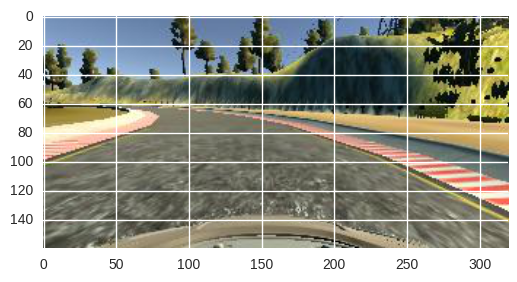

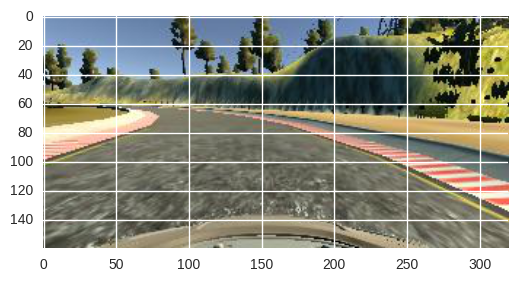

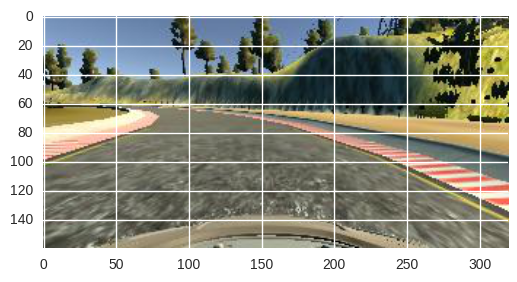

In [19]:
for img in X_all[:3]:
    plt.imshow(img)
    plt.show()

## Building a Convnet in Keras

1. Split the data in train/test sets.
2. Build a keras model for regression. 

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.20, random_state=23)

In [21]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

def get_model():
    lr = 0.0001
    weight_init='glorot_normal'
    opt = RMSprop(lr)
    loss = 'mean_squared_error'

    model = Sequential()

    model.add(Convolution2D(3, 3, 3, init=weight_init, border_mode='same', activation='relu', input_shape=(ROWS, COLS, CHANNELS)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(24, 3, 3, init=weight_init, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(36, 3, 3, init=weight_init, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(48, 3, 3, init=weight_init, border_mode='same',  activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(80, activation='relu', init=weight_init))
    model.add(Dense(16, activation='relu', init=weight_init))
    
    model.add(Dropout(0.25))
    model.add(Dense(1, init=weight_init, activation='linear'))

    model.compile(optimizer=opt, loss=loss)

    return model
    
model = get_model()
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_5 (Convolution2D)  (None, 160, 320, 3)   84          convolution2d_input_2[0][0]      
____________________________________________________________________________________________________
maxpooling2d_5 (MaxPooling2D)    (None, 80, 160, 3)    0           convolution2d_5[0][0]            
____________________________________________________________________________________________________
convolution2d_6 (Convolution2D)  (None, 80, 160, 24)   672         maxpooling2d_5[0][0]             
____________________________________________________________________________________________________
maxpooling2d_6 (MaxPooling2D)    (None, 40, 80, 24)    0           convolution2d_6[0][0]            
___________________________________________________________________________________________

In [ ]:
nb_epoch = 40
batch_size = 64

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')   
save_weights = ModelCheckpoint('new_model.h5', monitor='val_loss', save_best_only=True)
        

model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=nb_epoch,
          validation_data=(X_test, y_test), verbose=1, shuffle=True, callbacks=[save_weights, early_stopping])


preds = model.predict(X_test, verbose=1)

print( "Test MSE: {}".format(mean_squared_error(y_test, preds)))
print( "Test RMSE: {}".format(np.sqrt(mean_squared_error(y_test, preds))))

In [16]:
js = model.to_json()
with open('model.json', 'w') as outfile:
    json.dump(js, outfile)